# Research of apartment listings

We have at our disposal data from the Yandex.Real Estate service — an archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years. We need to learn how to determine the market value of real estate.

For each apartment for sale, two types of data are available. The first are entered by the user, the second are obtained automatically based on cartographic data. For example, the distance to the center, airport, nearest park and ponds.

Performed by:</br>
Emil Gaibaliev</br>
Levon Abramian</br>
Sofia Romanenko

In [1]:
!pip install --upgrade pip
!pip install pgmpy -q
!pip install umap-learn -q




# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas and seaborn settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format pandas float display
pd.options.mode.chained_assignment = None  # Suppress warnings for chained assignments
sns.set_theme(rc={'figure.figsize': (11.7, 8.27)})  # Set default seaborn figure size

# Libraries for advanced visualizations
import plotly.express as px
import networkx as nx

# Libraries for clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Libraries for modeling and preprocessing
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Metrics and statistical tests
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import wilcoxon, ttest_rel

# Libraries for hierarchical clustering
import scipy.cluster.hierarchy as sch

# Libraries for graph-based and structured modeling
from pgmpy.estimators import HillClimbSearch, BicScore

# Collections
from collections import defaultdict


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/ef/7d/500c9ad20238fcfcb4cb9243eede163594d7020ce87bd9610c9e02771876/pip-24.3.1-py3-none-any.whl.metadata
  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
data = pd.read_csv('./real_estate_data.csv', sep='\t')

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.000,108.000,2019-03-07T00:00:00,3,2.700,16.000,51.000,8,NaN,...,25.000,NaN,Санкт-Петербург,18863.000,16028.000,1.000,482.000,2.000,755.000,NaN
1,7,3350000.000,40.400,2018-12-04T00:00:00,1,NaN,11.000,18.600,1,NaN,...,11.000,2.000,посёлок Шушары,12817.000,18603.000,0.000,NaN,0.000,NaN,81.000
2,10,5196000.000,56.000,2015-08-20T00:00:00,2,NaN,5.000,34.300,4,NaN,...,8.300,0.000,Санкт-Петербург,21741.000,13933.000,1.000,90.000,2.000,574.000,558.000
3,0,64900000.000,159.000,2015-07-24T00:00:00,3,NaN,14.000,NaN,9,NaN,...,NaN,0.000,Санкт-Петербург,28098.000,6800.000,2.000,84.000,3.000,234.000,424.000
4,2,10000000.000,100.000,2018-06-19T00:00:00,2,3.030,14.000,32.000,13,NaN,...,41.000,NaN,Санкт-Петербург,31856.000,8098.000,2.000,112.000,1.000,48.000,121.000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

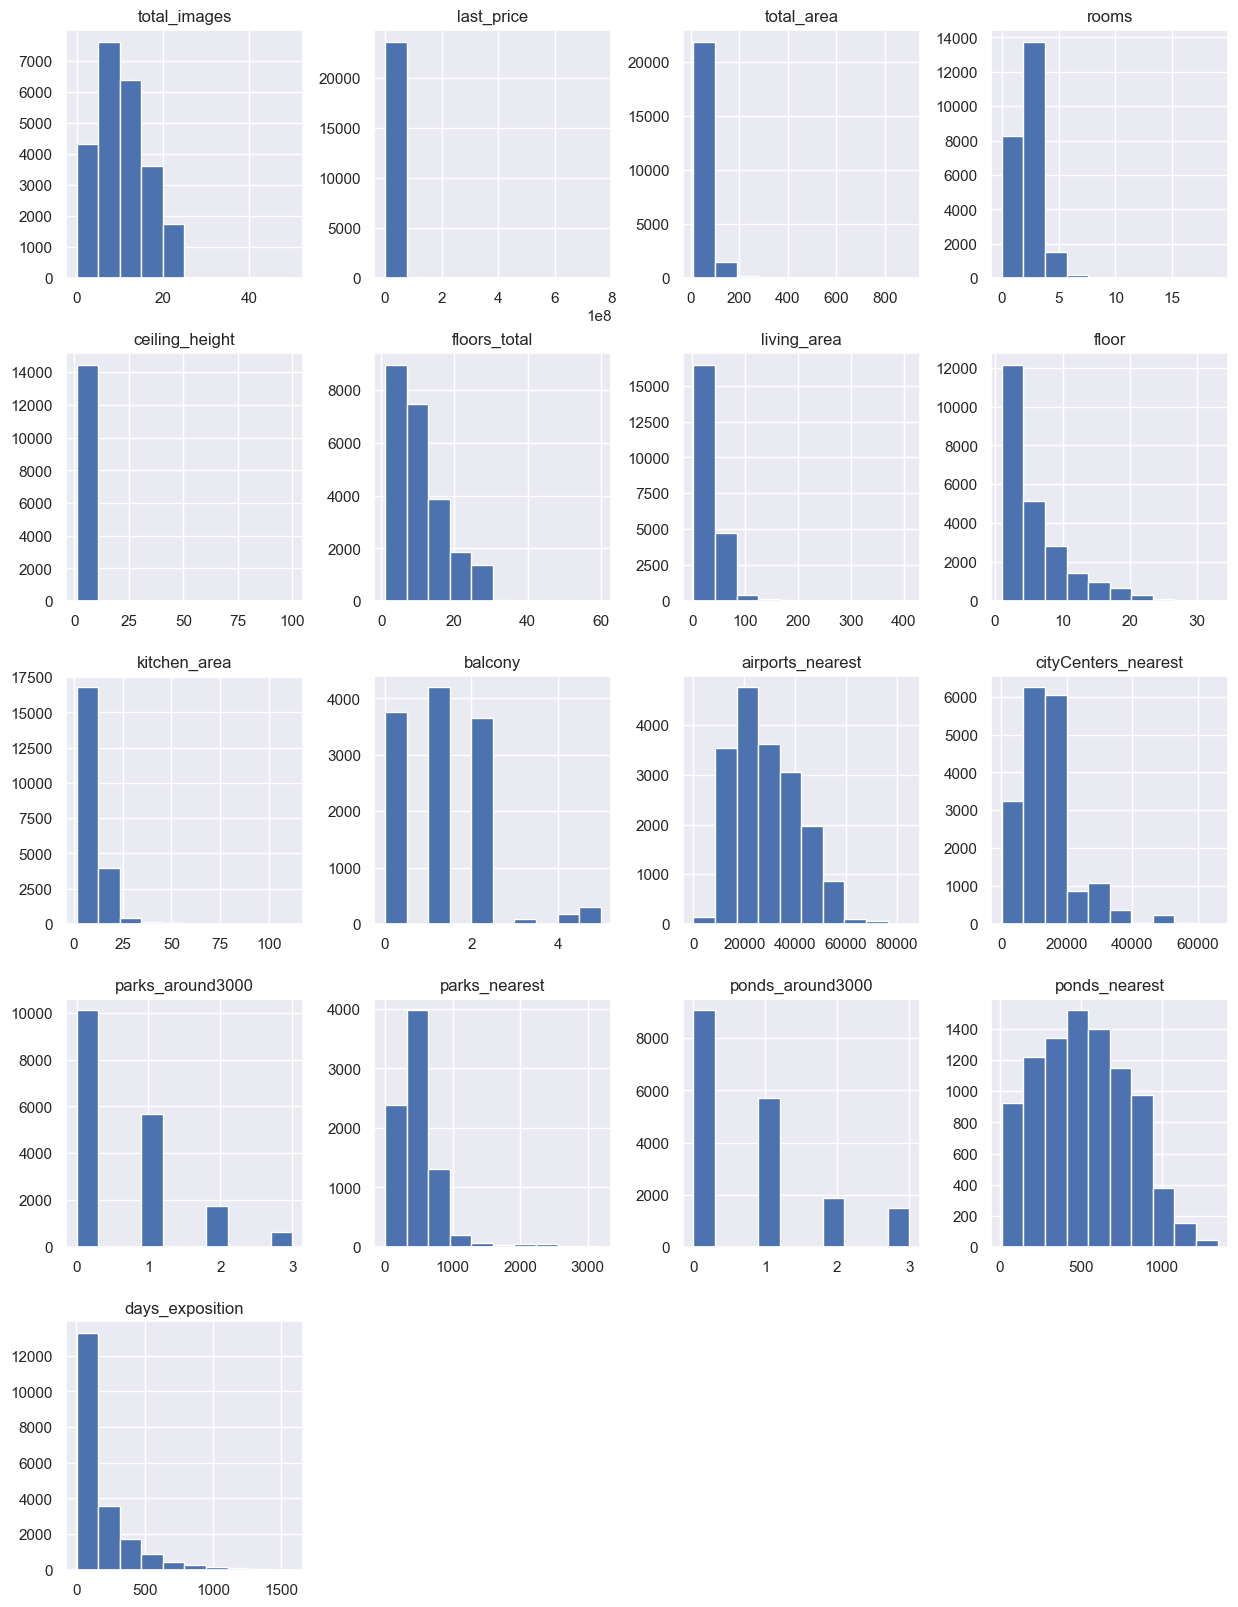

In [6]:
data.hist(figsize=(15, 20));

## Data preprocessing. Handling missing values

In [7]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Missing values percent' + "\n", fontsize = 22)    
        );    
    except:
        print('No missing values left')

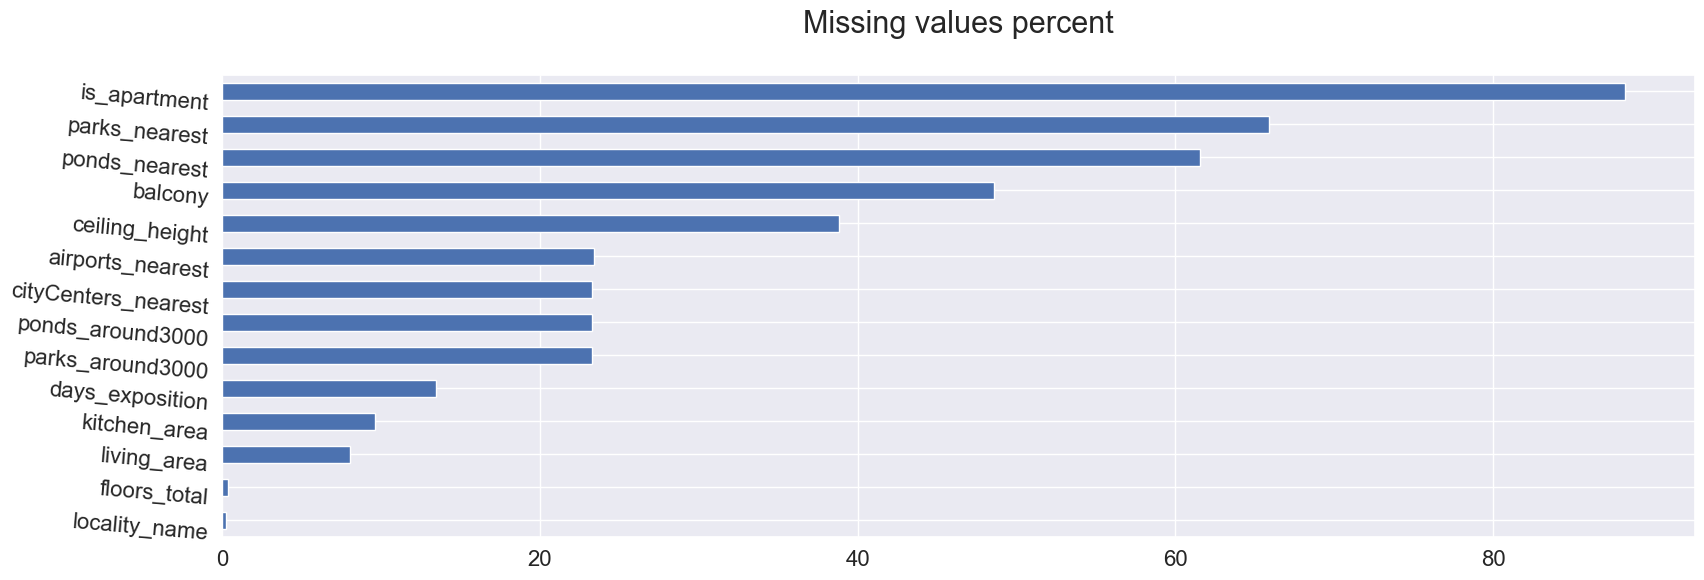

In [8]:
pass_value_barh(data)

In [9]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})

In [10]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

It is logical to assume that blank values in this column mean False.

In [11]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].unique()

C:\Users\Ilia\AppData\Local\Temp\ipykernel_16460\3367356441.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


array([False,  True])

It is logical to replace gaps in the balcony column with 0, since if the owner did not indicate the number of balconies, then most likely there are none.

In [12]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [13]:
data['balcony'] = data['balcony'].fillna(0)

We will do the same with parks and ponds.

In [14]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

**Columns with distances to the nearest parks and ponds mostly consist of NaNs. Moreover, these NaNs are either difficult or impossible to fill. The dataset contains columns with Boolean values about the presence of these objects in the vicinity, and missing values in them can be filled. Thus, the fields with distance seem redundant for this dataset and are unlikely to improve the quality of the prediction model. It is worth removing them.**

In [15]:
data = data.drop(columns=['ponds_nearest', 'parks_nearest'])

### Distance fields processing

The columns with the distance to the nearest airport has relatively many gaps. Let's make fields with a Boolean value from them: 1 if the distance to the nearest airport is less than a certain value; otherwise - 0. This will be enough for the prediction model.

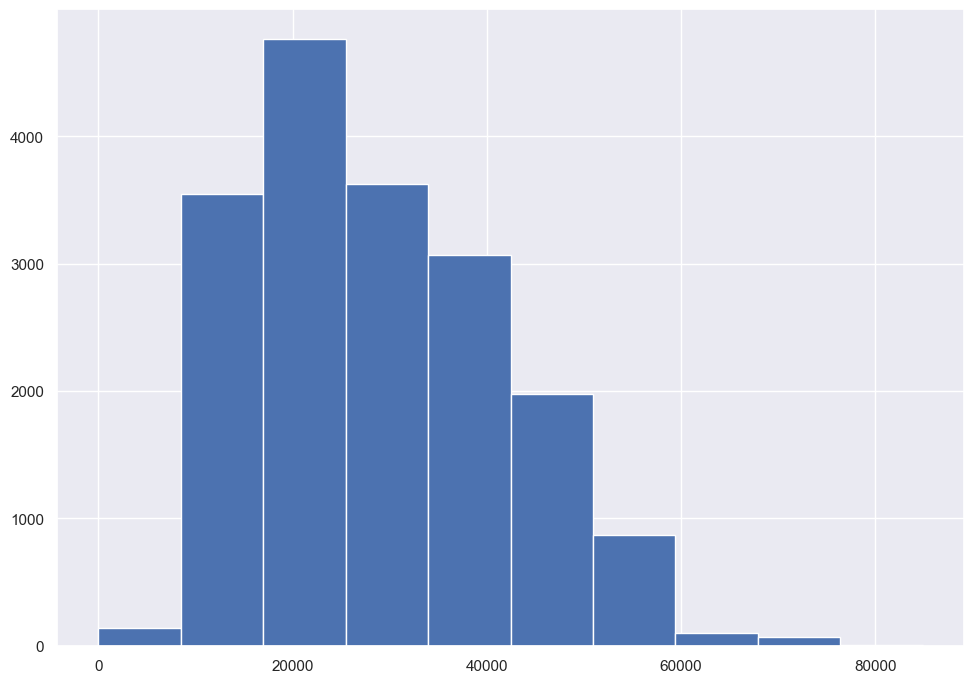

In [16]:
data['airports_nearest'].hist();

The graph shows that objects are most often located at a distance of approximately 15 to 30 kilometers from the airport. Let's choose a value of 30,000 meters as the boundary.

In [17]:
data['airports_nearest'].median()

np.float64(26726.0)

In [18]:
data['airports_around30000'] = data['airports_nearest']<=30000

In [19]:
data = data.drop(columns=['airports_nearest'])

## EDA

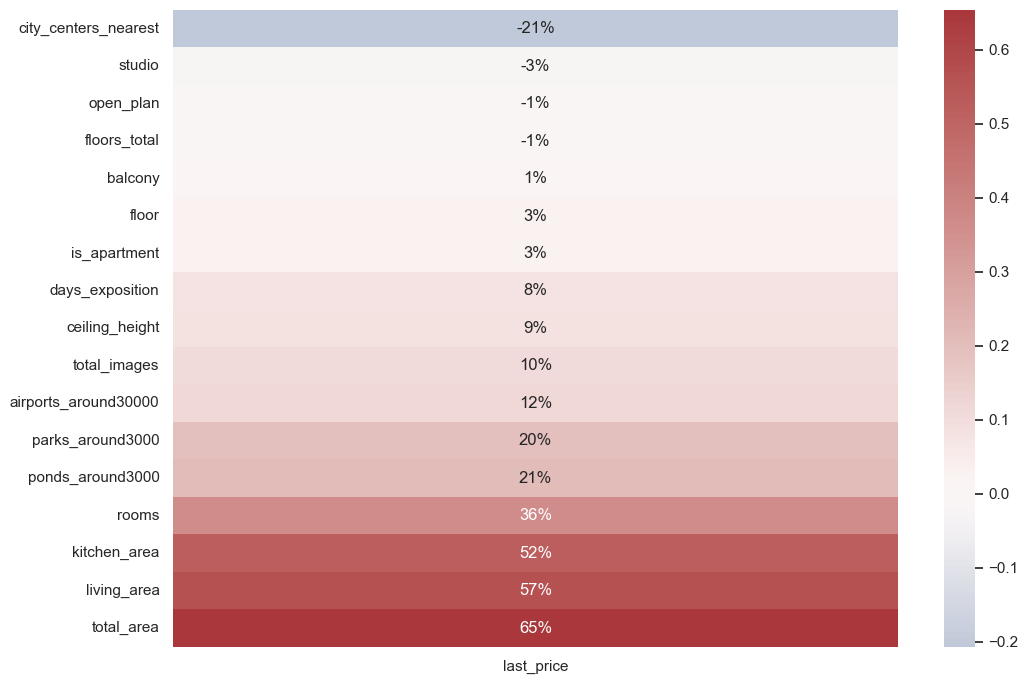

In [20]:
df_corr = data.corr(numeric_only=True)
sns.heatmap(
    df_corr.loc[:, ['last_price']].drop('last_price').sort_values('last_price'),
    annot=True, fmt='.0%', cmap='vlag', center=0
);

As it was expected, the larger the area, the more expensive the apartment. And, on the contrary, the less distance to the center, the higher the last price of object. There are several columns with different areas, which, probably, also have high correlation between each other but in this laboratory only univariate data analysis techniques are required. So, regardless of potential multicollinearity, these columns will be part of the eventual solve.

In [21]:
# data = data.drop(columns=['living_area', 'kitchen_area', 'rooms'])

In [22]:
data[data['floors_total'].isna()]['floor'].unique()

array([ 4,  1, 12,  8,  9, 22, 15,  6,  7,  3, 18, 13, 24, 21, 11,  2,  5,
       19, 20, 14, 17, 23, 10])

In cases where there is no information about the total number of floors in a building, the object is not always located on the first floor. Thus, it cannot be assumed that the building has only one floor and this is a potential cause of omissions. Since there are very few records with missing values in this field, in this case they can simply be deleted.

In [23]:
data = data.dropna(subset=['floors_total'])

The field with the names of settlements also has very few gaps, we can delete records with them.

In [24]:
data = data.dropna(subset=['locality_name'])

In [25]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [26]:
data['locality_name'] = \
data['locality_name'].str.lower().str.replace('городской поселок', 'поселок городского типа').str.replace('ё', 'е')

### Distance to the center

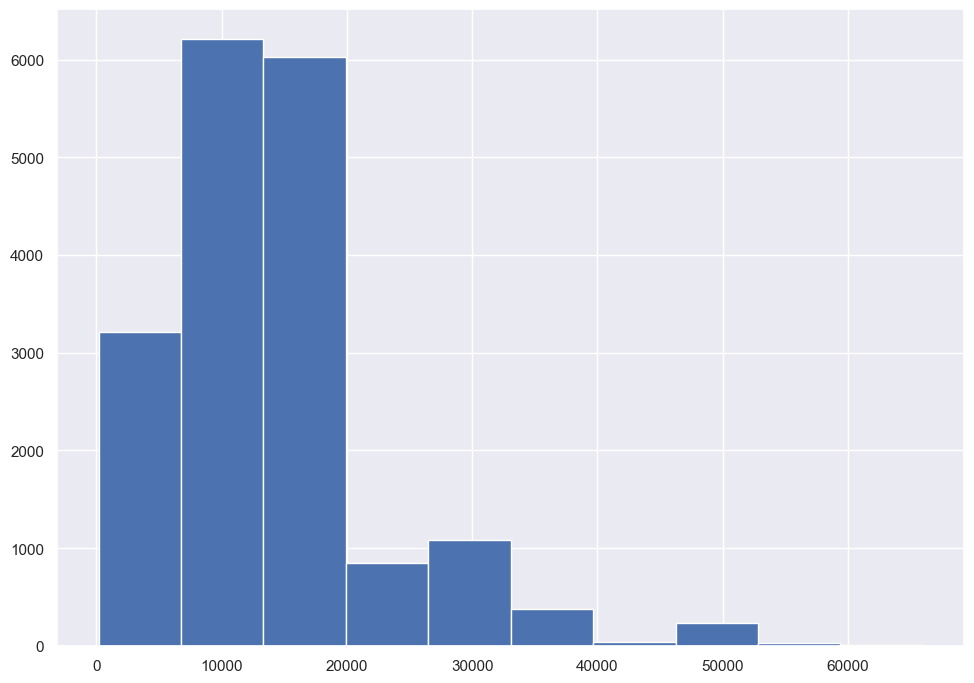

In [27]:
data['city_centers_nearest'].hist();

In [28]:
data['city_centers_nearest'].median()

np.float64(13096.5)

In [29]:
data['city_centers_nearest'] = data['city_centers_nearest'].fillna(data['city_centers_nearest'].median())

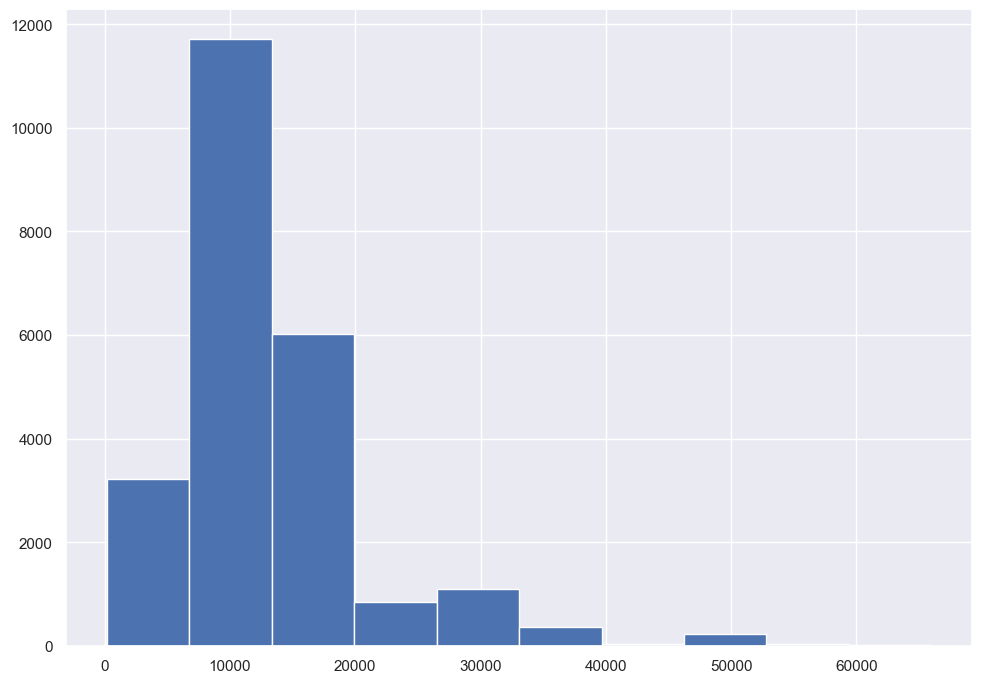

In [30]:
data['city_centers_nearest'].hist();

This is one of the columns that should really be treated wil multivariate data analysis techniques. There are lots of settlements in the dataset, and it should be taken into account. Moreover, this feature has quite high correlation with the target column. Just fitting NaNs with one specific value for all objects in this case distort the distribution. However, in this experiment median value is used because of outliers that can be seen on the graph.

### Ceiling

In [31]:
print(data['ceiling_height'].median())
print(data['ceiling_height'].mean())

2.65
2.7712830605621157


In [32]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

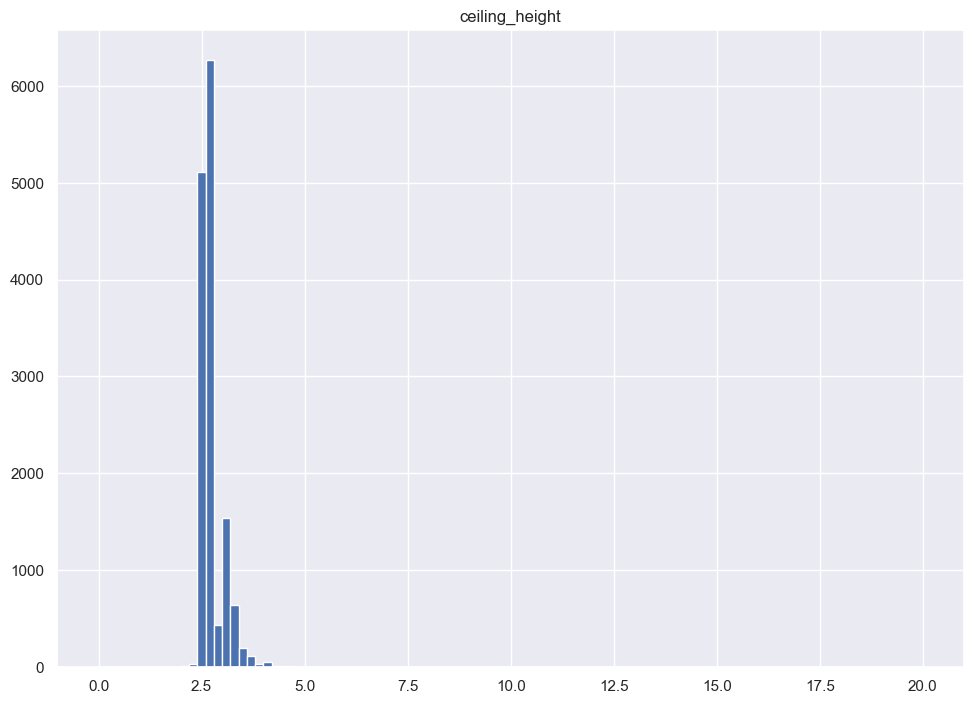

In [33]:
data.hist('ceiling_height', bins=100, range=(0, 20));

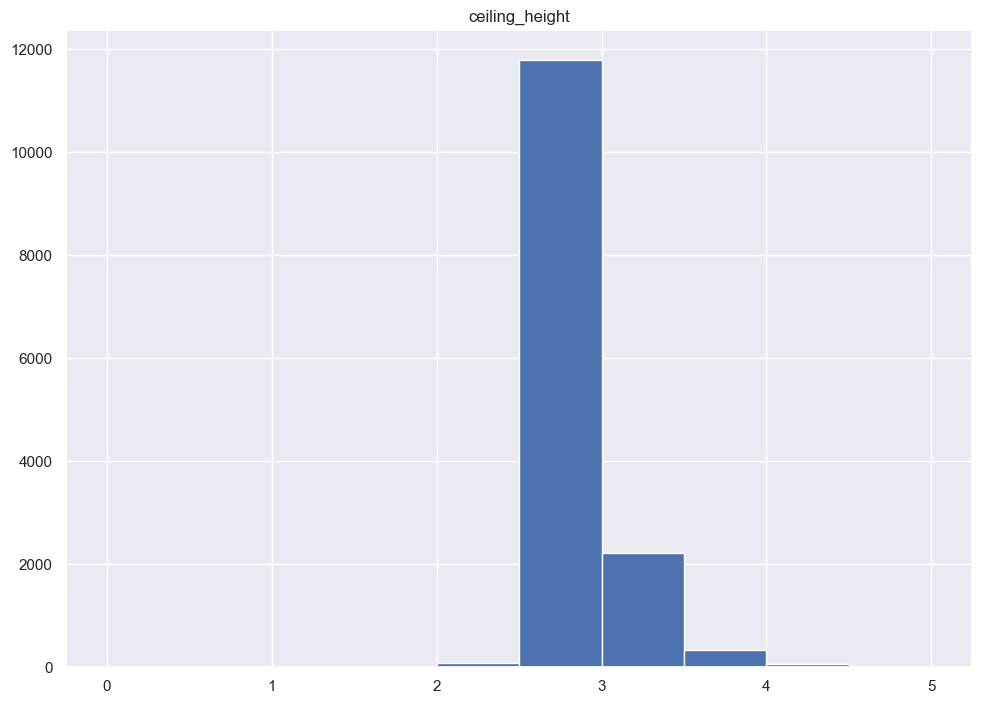

In [34]:
data.hist('ceiling_height', bins=10, range=(0, 5));

**Based on the histogram, we can conclude that there are not many outliers, they do not distort the data much. We can process values in the range from 24 to 32 meters, dividing the values by 10, since most likely, errors were made when filling in and instead of 3.2 meters, data on 32 meters was entered, etc. Values greater than 10.3 meters and less than 2.4 can be discarded, since it is not possible to clearly select a logical replacement. The ceiling height can hardly be equal to 14 meters in the general case or be less than 2.4 m.**

In [35]:
data.loc[(data['ceiling_height'] >= 24) & (data['ceiling_height'] <= 32), 'ceiling_height'] = data['ceiling_height'] / 10

In [36]:
#проверим список уникальных значений
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

There are a lot of gaps in the ceiling height field. They should to be filled within the number of floors for each building, separately for St. Petersburg and other settlements. In this work they will be filled with median due to outliers.

In [37]:
# for floor in data['floors_total'].unique():
#     data.loc[(data['floors_total'] == floor) & (data['locality_name']!='санкт-петербург') & (data['ceiling_height'].isna()), 'ceiling_height'] = \
#     data.loc[(data['floors_total'] == floor) & (data['locality_name']!='санкт-петербург'), 'ceiling_height'].median()
    
#     data.loc[(data['floors_total'] == floor) & (data['locality_name']=='санкт-петербург') & (data['ceiling_height'].isna()), 'ceiling_height'] = \
#     data.loc[(data['floors_total'] == floor) & (data['locality_name']=='санкт-петербург'), 'ceiling_height'].median()

In [38]:
data['ceiling_height'].median()

np.float64(2.65)

In [39]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

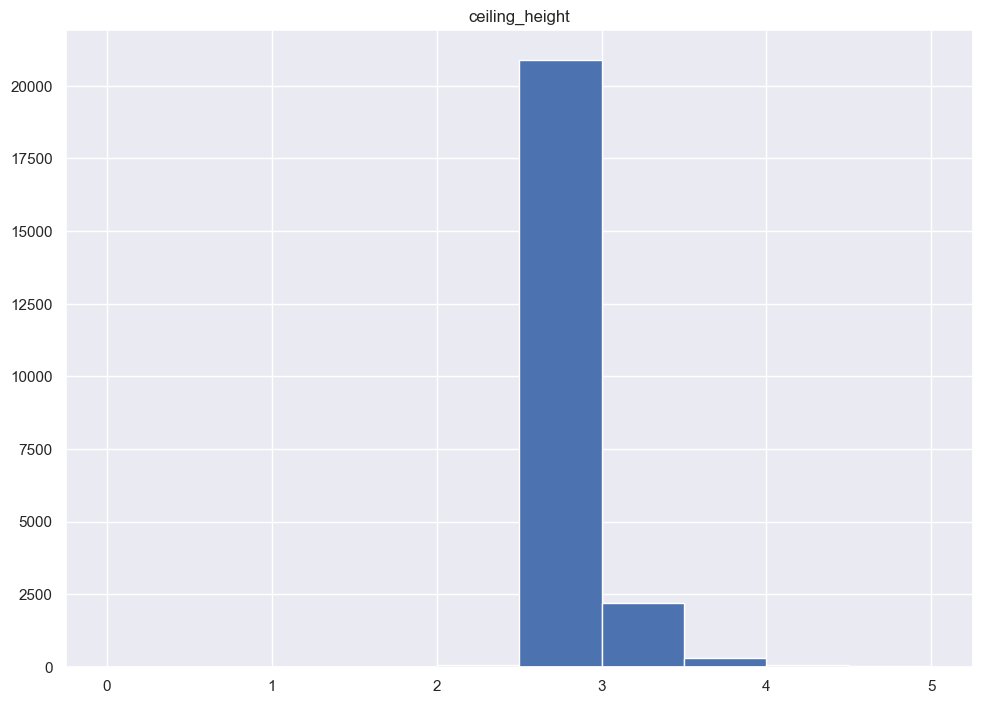

In [40]:
data.hist('ceiling_height', bins=10, range=(0, 5));

Distribution, as it was expected, has changed. It happened because of filling lots of NaNs with synthetic value.

### Days exposition

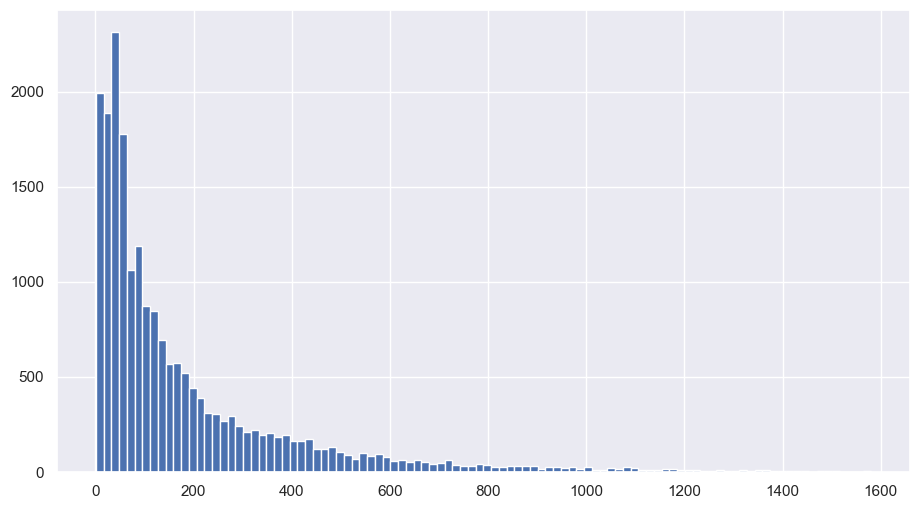

In [41]:
data['days_exposition'].hist(bins=100, figsize=(11,6));

Days_exposition columns has a low correlation with target value, moreover it has quite many missing values which can not be filled. It's better to just drop it.

In [42]:
data = data.drop(columns=['days_exposition'])

### First day exposition

We will use this column to get new ones with year and month of publishing. Thus, the model will also consider period which might help with making prediction.

In [43]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [44]:
data['publishing_year'] = data['first_day_exposition'].dt.year
data['publishing_month'] = data['first_day_exposition'].dt.month

In [45]:
data = data.drop(columns=['first_day_exposition'])

### Living area

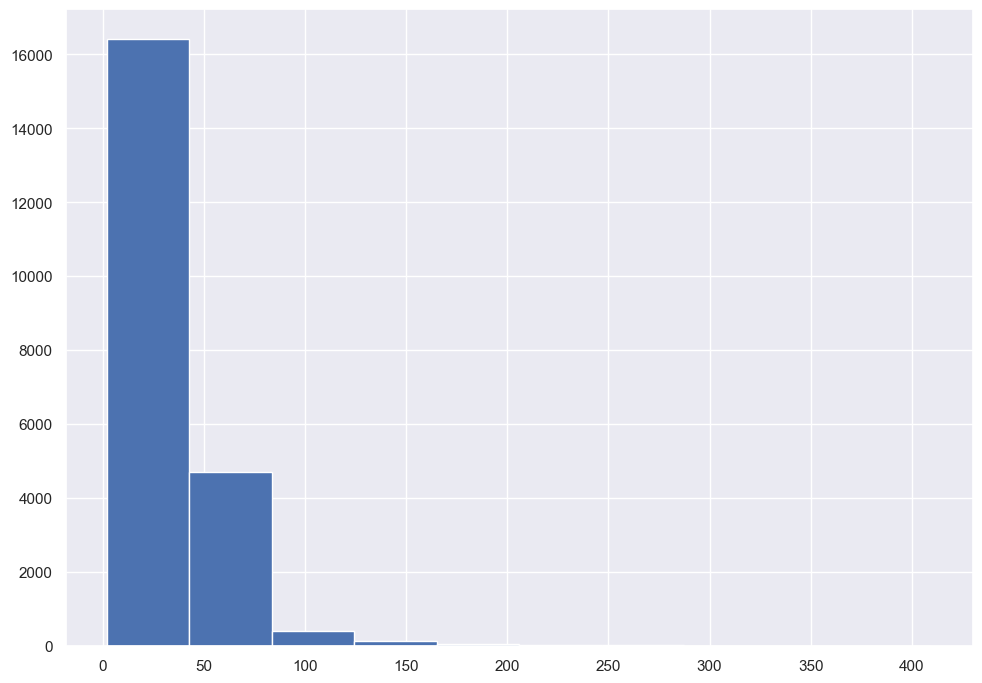

In [46]:
data['living_area'].hist();

In [47]:
data['living_area'].median()

np.float64(30.0)

In [48]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())

### Kitchen area

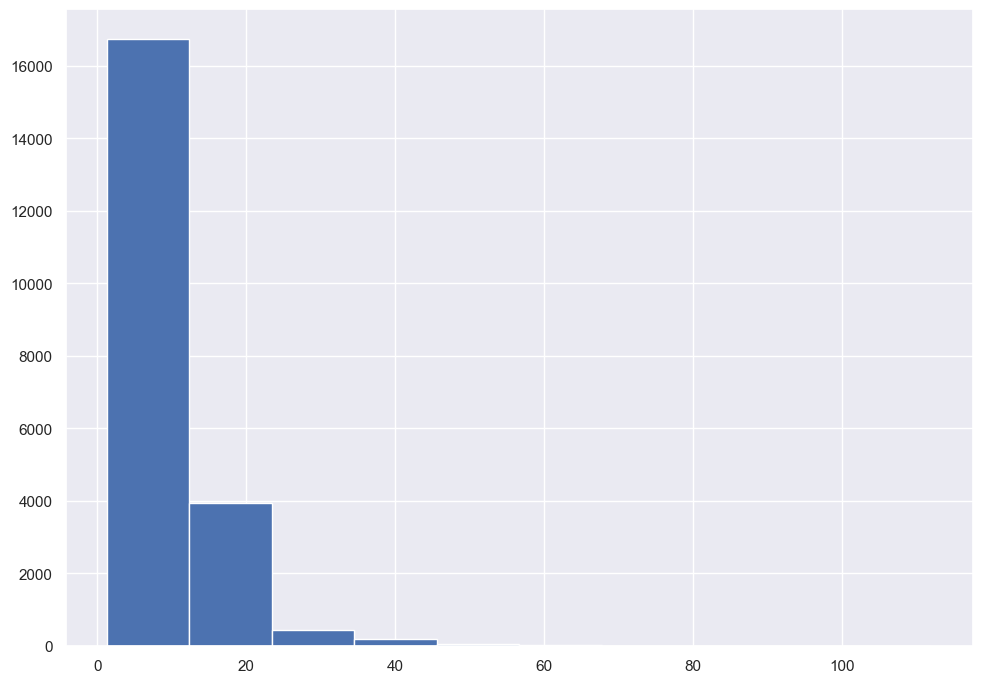

In [49]:
data['kitchen_area'].hist();

In [50]:
data['kitchen_area'].median()

np.float64(9.1)

In [51]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

Both kitchen_area and living_area should be filled with other features like rooms, total_area, settlement taken into account.

## Work with outliers

In [52]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,city_centers_nearest,parks_around3000,ponds_around3000,publishing_year,publishing_month
count,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000,23565.000
mean,9.878,6540058.260,60.323,2.071,2.704,10.676,34.102,5.878,10.423,0.594,13936.770,0.469,0.590,2017.371,6.402
std,5.681,10910934.722,35.657,1.079,0.702,6.595,21.189,4.871,5.632,0.961,7555.477,0.748,0.884,1.037,3.493
min,0.000,12190.000,12.000,0.000,1.000,1.000,2.000,1.000,1.300,0.000,181.000,0.000,0.000,2014.000,1.000
25%,6.000,3400000.000,40.000,1.000,2.600,5.000,19.000,2.000,7.300,0.000,10935.000,0.000,0.000,2017.000,3.000
50%,9.000,4646000.000,52.000,2.000,2.650,9.000,30.000,4.000,9.100,0.000,13096.500,0.000,0.000,2017.000,6.000
75%,14.000,6790000.000,69.700,3.000,2.700,16.000,41.100,8.000,11.410,1.000,15237.000,1.000,1.000,2018.000,10.000
max,50.000,763000000.000,900.000,19.000,100.000,60.000,409.700,33.000,112.000,5.000,65968.000,3.000,3.000,2019.000,12.000


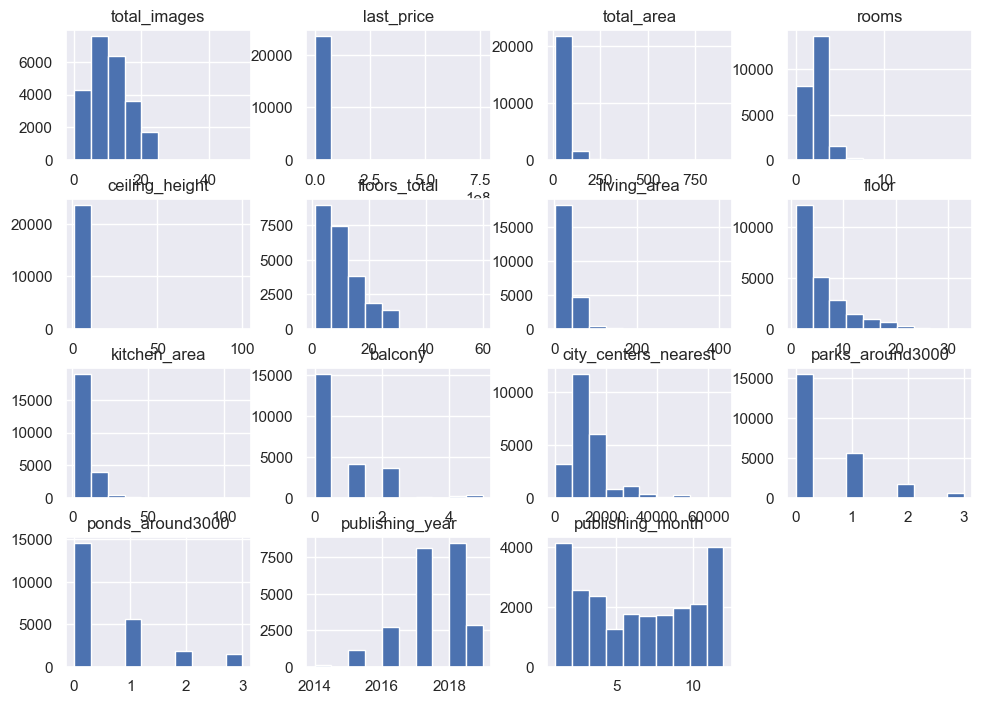

In [53]:
data.hist();

### Total images

In [54]:
data['total_images'].quantile(0.99)

np.float64(20.0)

In [55]:
data = data[data['total_images']<=20]

### Price

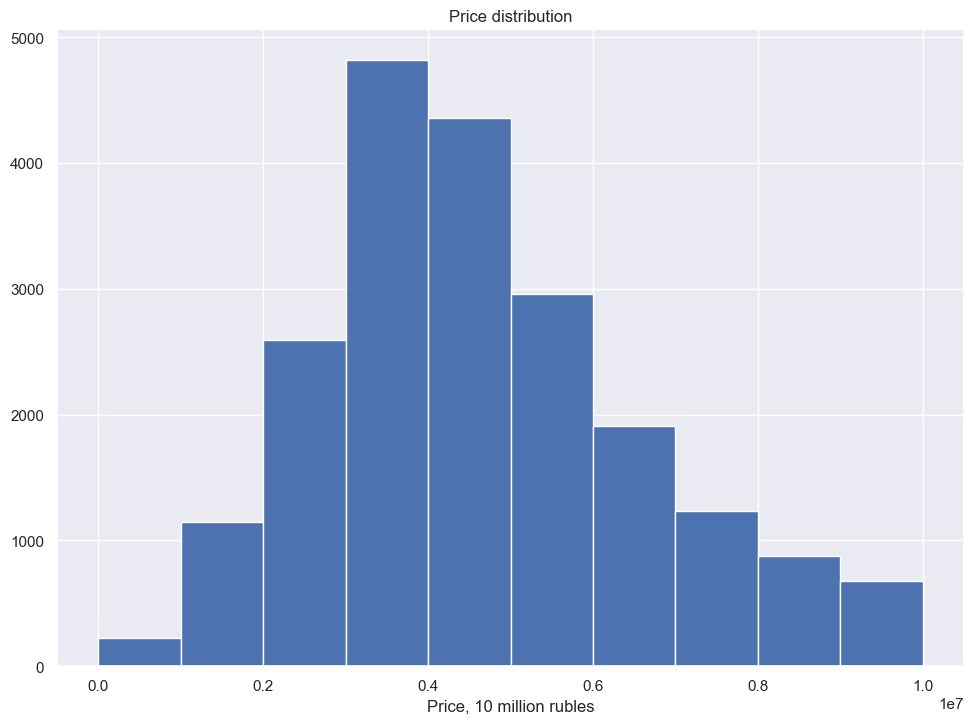

In [56]:
data['last_price'].hist(range=(0, 1e7))
plt.title('Price distribution')
plt.xlabel('Price, 10 million rubles');

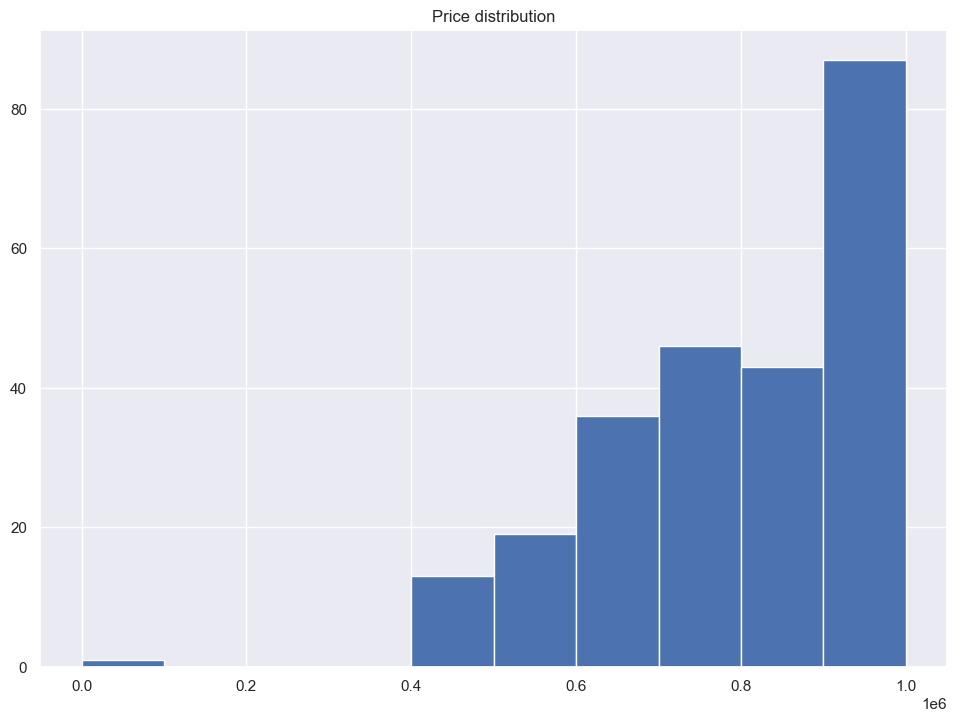

In [57]:
data['last_price'].hist(range=(0, 1e6))
plt.title('Price distribution');

In [58]:
print(data['last_price'].quantile(0.01))
print(data['last_price'].quantile(0.99))

1000000.0
36000000.0


In [59]:
data = data.loc[(data['last_price']>=1000000) & (data['last_price']<=36000000)]

### Total area

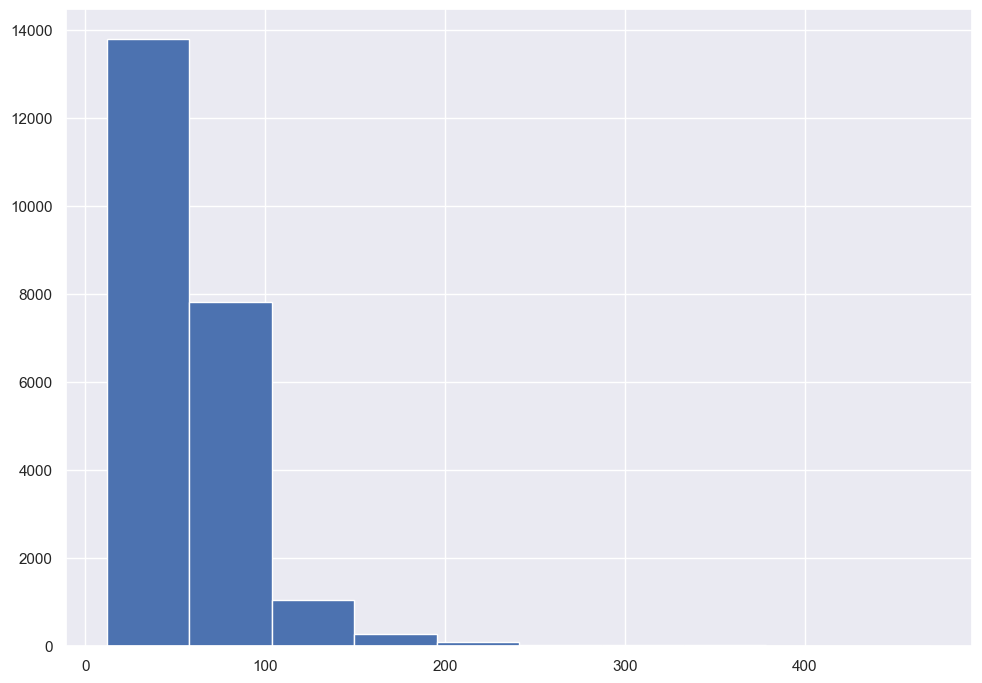

In [60]:
data['total_area'].hist();

In [61]:
print(data['total_area'].quantile(0.01))
print(data['total_area'].quantile(0.99))

25.3
170.0


In [62]:
data = data.loc[(data['total_area']>=20) & (data['total_area']<=200)]

### Living area

In [63]:
print(data['living_area'].quantile(0.01))
print(data['living_area'].quantile(0.99))

13.1
92.80999999999985


In [64]:
data = data.loc[(data['living_area']>=13) & (data['living_area']<=95)]

### Kitchen area

In [65]:
print(data['kitchen_area'].quantile(0.01))
print(data['kitchen_area'].quantile(0.99))

5.0
30.0


In [66]:
data = data.loc[(data['kitchen_area']>=5) & (data['kitchen_area']<=31)]

### Ceiling height

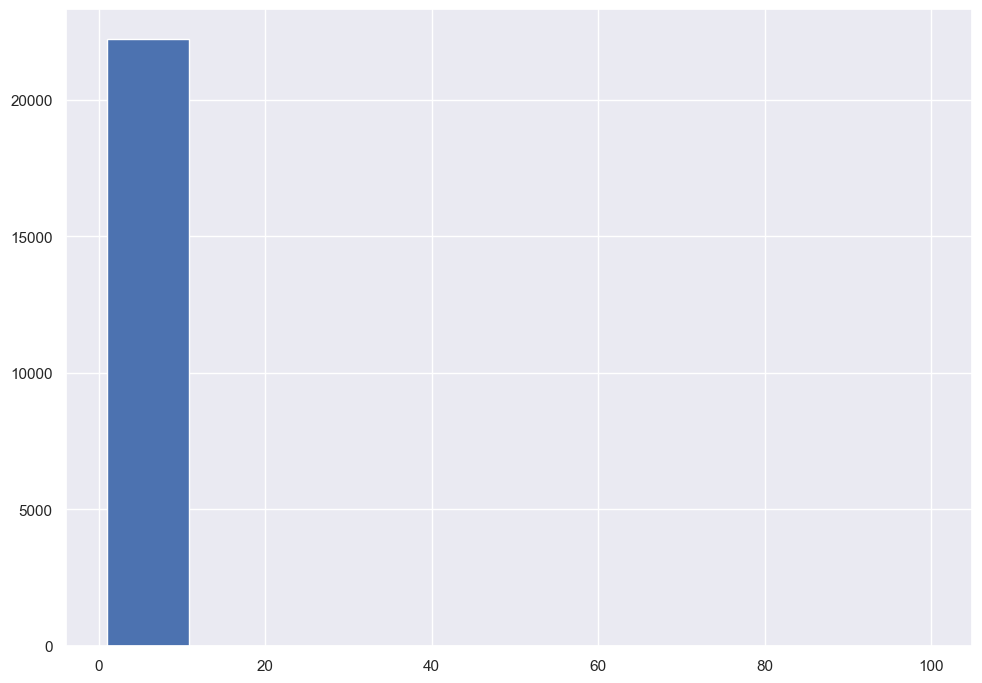

In [67]:
data['ceiling_height'].hist();

In [68]:
print(data['ceiling_height'].quantile(0.01))
print(data['ceiling_height'].quantile(0.99))

2.5
3.5


In [69]:
data = data[(data['ceiling_height']>=2.4) & (data['ceiling_height']<=4)]

### Floors total

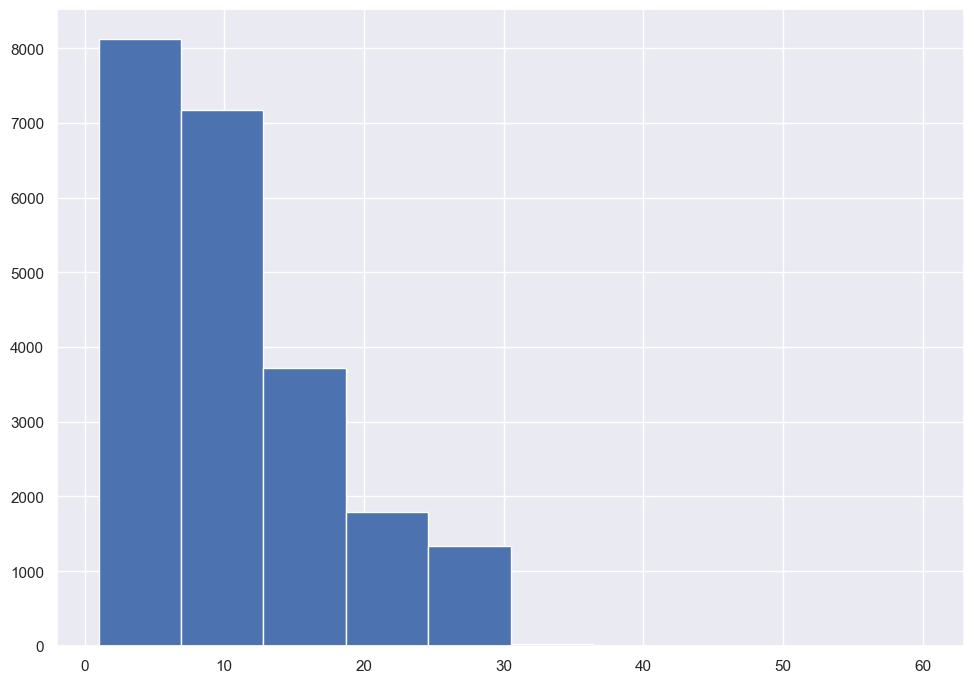

In [70]:
data['floors_total'].hist();

In [71]:
data['floors_total'].quantile(0.99)

np.float64(26.0)

In [72]:
data = data[data['floors_total']<=30]

### City centers nearest

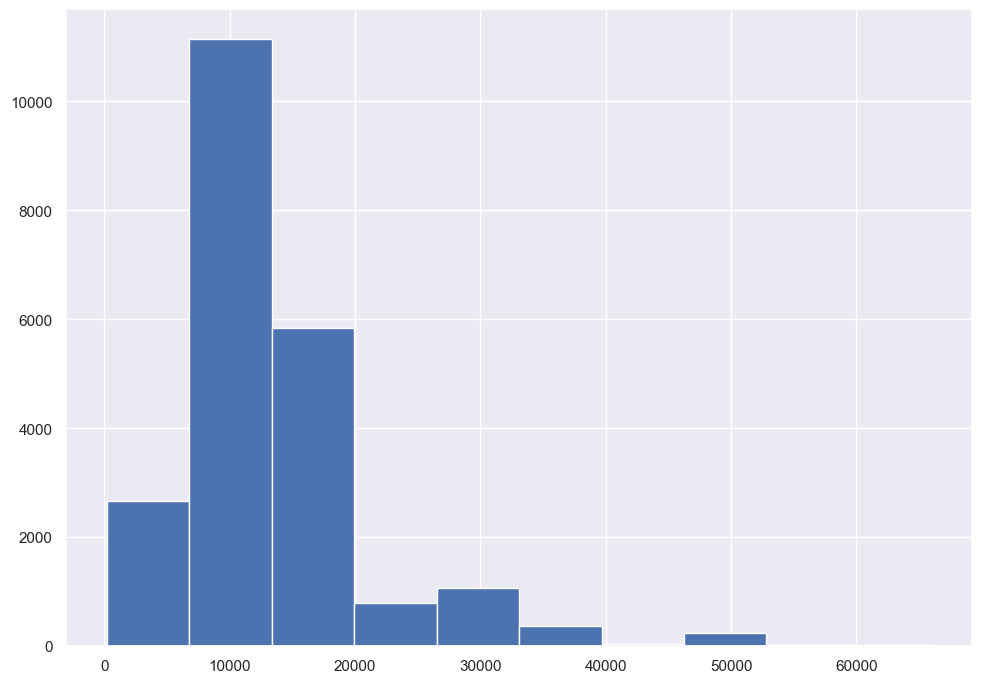

In [73]:
data['city_centers_nearest'].hist();

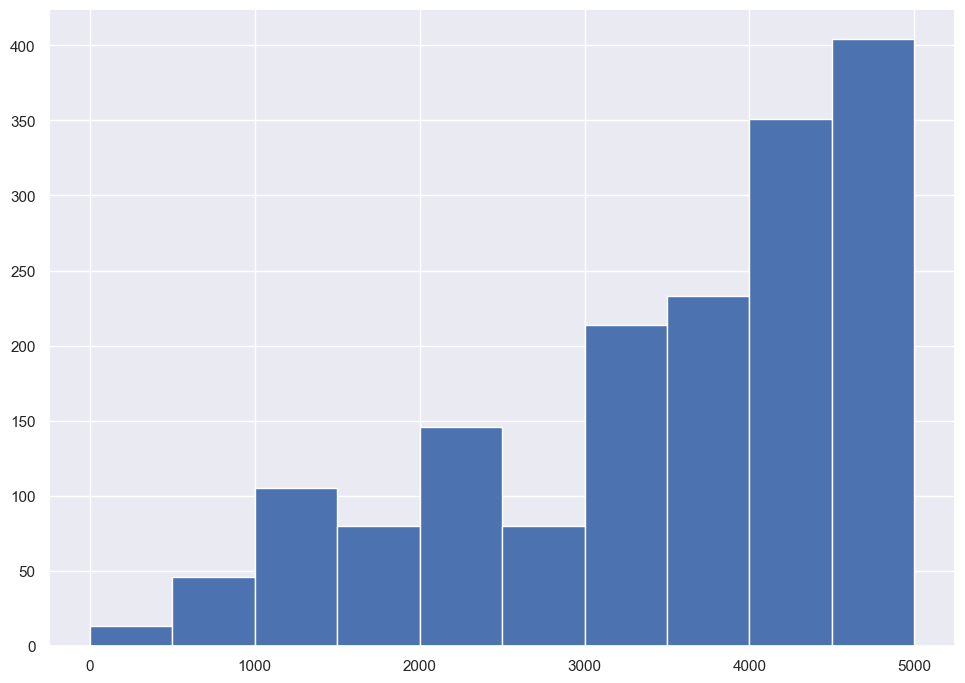

In [74]:
data['city_centers_nearest'].hist(range=(0, 5000));

In [75]:
print(data['city_centers_nearest'].quantile(0.01))
print(data['city_centers_nearest'].quantile(0.99))

1888.48
48446.92000000002


In [76]:
data = data.loc[(data['city_centers_nearest']>=1000) & (data['city_centers_nearest']<=50000)]

### Year

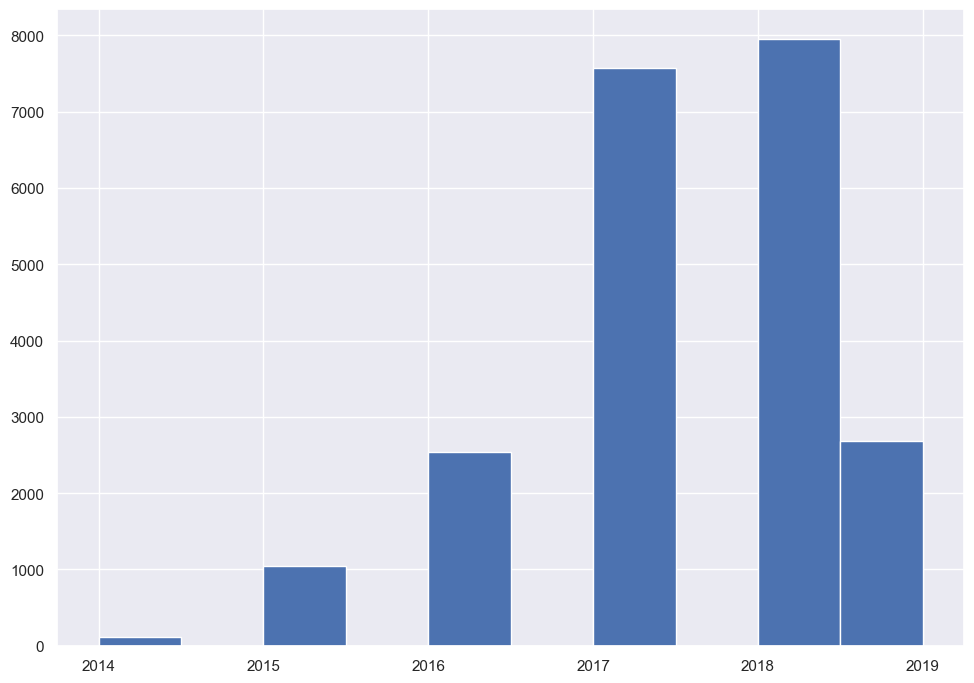

In [77]:
data['publishing_year'].hist();

In [78]:
data = data[data['publishing_year']>2014]

In [79]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,city_centers_nearest,parks_around3000,ponds_around3000,publishing_year,publishing_month
count,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000,21781.000
mean,9.810,5572420.428,56.449,2.001,2.683,10.862,32.085,5.944,9.853,0.602,13890.798,0.443,0.555,2017.399,6.378
std,5.557,3705531.376,22.833,0.946,0.187,6.541,14.376,4.881,3.749,0.963,6671.066,0.717,0.851,1.003,3.479
min,0.000,1000000.000,20.000,0.000,2.400,1.000,13.000,1.000,5.000,0.000,1015.000,0.000,0.000,2015.000,1.000
25%,6.000,3450000.000,40.000,1.000,2.600,5.000,19.000,2.000,7.300,0.000,11250.000,0.000,0.000,2017.000,3.000
50%,9.000,4600000.000,51.000,2.000,2.650,9.000,30.000,4.000,9.100,0.000,13096.500,0.000,0.000,2017.000,6.000
75%,14.000,6500000.000,67.160,3.000,2.700,16.000,40.000,8.000,11.000,1.000,15288.000,1.000,1.000,2018.000,10.000
max,20.000,36000000.000,200.000,7.000,4.000,29.000,95.000,27.000,31.000,5.000,49984.000,3.000,3.000,2019.000,12.000


### Feature processing

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21781 entries, 0 to 23697
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21781 non-null  int64  
 1   last_price            21781 non-null  float64
 2   total_area            21781 non-null  float64
 3   rooms                 21781 non-null  int64  
 4   ceiling_height        21781 non-null  float64
 5   floors_total          21781 non-null  float64
 6   living_area           21781 non-null  float64
 7   floor                 21781 non-null  int64  
 8   is_apartment          21781 non-null  bool   
 9   studio                21781 non-null  bool   
 10  open_plan             21781 non-null  bool   
 11  kitchen_area          21781 non-null  float64
 12  balcony               21781 non-null  float64
 13  locality_name         21781 non-null  object 
 14  city_centers_nearest  21781 non-null  float64
 15  parks_around3000      21

In [81]:
data['is_spb'] = data['locality_name']=='санкт-петербург'

In [82]:
data = data.drop(columns=['locality_name'])

In [83]:
data[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']] = \
data[['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']].astype(int)

## Model with initial data

In [84]:
initial = pd.read_csv('./real_estate_data.csv', sep='\t')

In [85]:
initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [86]:
#drop objects and columns with too many nans
initial = initial.drop(columns=[
    'first_day_exposition', 'ceiling_height', 'is_apartment', 'balcony', 'locality_name', 'parks_nearest', 'ponds_nearest'
])

In [87]:
initial = initial.dropna()

In [88]:
X = initial.drop(columns=['last_price'])
y = initial['last_price']

In [89]:
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, test_size=0.25)

In [90]:
model_init = LinearRegression()
model_init.fit(X_train_init, y_train_init)
y_pred = model_init.predict(X_test_init)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test_init, y_pred),
        r2_score(y_test_init, y_pred)
    )
)

RMSE:7874927.96 R2:0.47 


## Model with processed data

In [91]:
data = data.sort_values(by=['publishing_year', 'publishing_month'])

In [92]:
X = data.drop(columns=['last_price'])
y = data['last_price']

In [93]:
X_train_pr = X[:15000]
y_train_pr = y[:15000]

X_test_pr = X[15000:]
y_test_pr = y[15000:]

Sorting and dividing manually because of timeseries.

In [94]:
print(X_train_pr.shape)
print(y_train_pr.shape)

print(X_test_pr.shape)
print(y_test_pr.shape)

(15000, 19)
(15000,)
(6781, 19)
(6781,)


In [95]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train_pr)
X_test_st = scaler.transform(X_test_pr)

In [96]:
model = LinearRegression()
model.fit(X_train_st, y_train_pr)
y_pred_pr = model.predict(X_test_st)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test_pr, y_pred_pr),
        r2_score(y_test_pr, y_pred_pr)
    )
)

RMSE:1964178.56 R2:0.71 


## Model with skewness treating

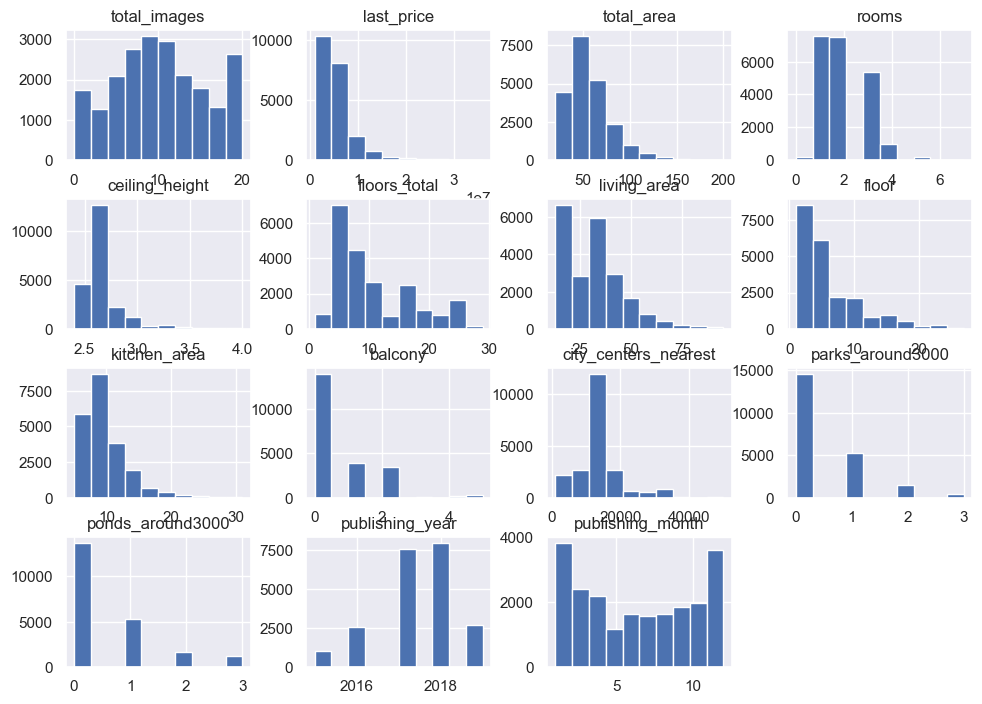

In [97]:
data.hist();

In [98]:
data['total_area'] = np.log(data['total_area'])
data['kitchen_area'] = np.log(data['kitchen_area'])
data['ceiling_height'] = np.log(data['ceiling_height'])
data['living_area'] = np.log(data['living_area'])
data['floor'] = np.log(data['floor'])

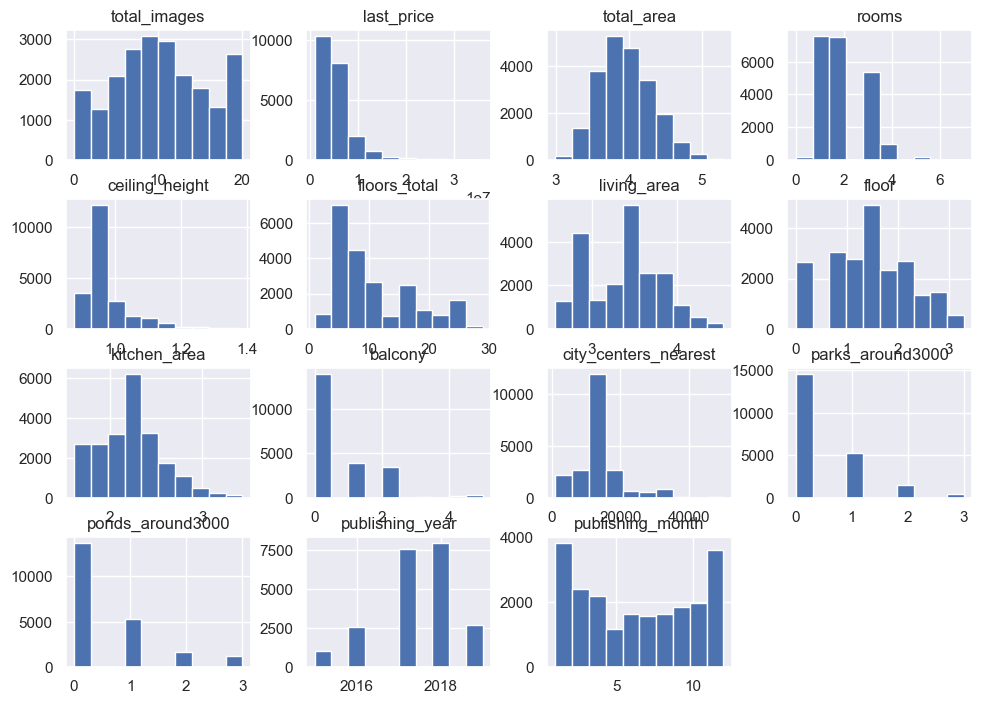

In [99]:
data.hist();

In [100]:
X = data.drop(columns=['last_price'])
y = data['last_price']

X_train = X[:15000]
y_train = y[:15000]

X_test = X[15000:]
y_test = y[15000:]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE:{:.2f} R2:{:.2f} '.format(
        root_mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    )
)

RMSE:2169627.59 R2:0.65 


It is clear that in this case, the asymmetry treating not only failed to improve the quality of predictions, but also led to its deterioration. This could happen for several reasons. For example, due to the loss of information in the process of artificial data distortion. Also, asymmetry is not always a problem, some data can be asymmetrical in nature.

## Own linear regression implementation

In [101]:
X_train['additional'] = 1
X_test['additional'] = 1

In [102]:
X = np.array(X_train, dtype=np.float64)
y = np.array(y_train)

X_test = np.array(X_test, dtype=np.float64)
y_test = np.array(y_test)

In [103]:
w = np.linalg.inv(X.T @ X) @ X.T @ y
result = X_test @ w

In [104]:
def root_mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.round(np.sqrt(mse), 2)
    return rmse

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)
    r2 = np.round(r2, 2)
    return r2

In [105]:
print('RMSE:', root_mean_squared_error(y_test, result))
print('R2:', r2_score(y_test, result))

RMSE: 2169627.59
R2: 0.65


## Conclusion

Thus, the univariate Data Analysis helps to improve prediction model's quality by saving a lot of data, adding new features, outliers, missings, noise treating etc. The more data a model has for training, the more relationships it can find. Handling outliers and noise makes it easier to identify significant features and prevents the model from distorting the results. In our case we got 3.63 times less error with the processed data than with the initial data, which is a significant improvement over the baseline model. However, sometimes using only univariate data analysis techniques is not enough to process data in the most appropriate way. Quite often it's needed to take relations between multiple features into account to get the best results.

## Model Performance Comparison with Classical Metrics

### Post-Univariate

In [127]:
df_2 = pd.read_csv('kmeans_2.csv')
df_2.head()

,total_images,last_price,total_area,rooms,floor,is_apartment,studio,open_plan,airports_nearest,cityCenters_nearest,days_exposition,weekday_exposition,month_exposition,year_exposition,is_spb,KMeans_Cluster
0,7,3350000.000,40.400,1,1,0,0,0,12817.000,18603.000,4.394,1,12,2018,0,0
1,10,5196000.000,56.000,2,4,0,0,0,21741.000,13933.000,6.324,3,8,2015,1,0
2,0,64900000.000,159.000,3,9,0,0,0,28098.000,6800.000,6.050,4,7,2015,1,0
3,2,10000000.000,100.000,2,13,0,0,0,31856.000,8098.000,4.796,1,6,2018,1,0
4,10,2890000.000,30.400,1,5,0,0,0,23186.132,14073.805,4.007,0,9,2018,0,0


In [151]:
def get_metrics(df, target_col = 'last_price'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    scaler = StandardScaler()
    X_train_st = scaler.fit_transform(X_train)
    X_test_st = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print(f'MAE:\t{mean_absolute_error(y_test, y_pred):_.2f}')
    print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):_.2f}')
    print(f'R\u00b2:\t{r2_score(y_test, y_pred):.2f}')
    return y_test, y_pred, X_test_st
   

In [152]:
y_test_multi, y_pred_multi, X_test_st_2 = get_metrics(df_2)

MAE:	2_208_745.70
RMSE:	5_945_807.65
R²:	0.61


In [155]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


rmse_initial = root_mean_squared_error(y_test_init, model_init.predict(X_test_init))
mae_initial = mean_absolute_error(y_test_init, model_init.predict(X_test_init))
r2_initial = r2_score(y_test_init, model_init.predict(X_test_init))
adj_r2_initial = adjusted_r2(r2_initial, len(y_test_init), X_test_init.shape[1])


rmse_univariate = root_mean_squared_error(y_test_pr, y_pred_pr)
mae_univariate = mean_absolute_error(y_test_pr, y_pred_pr)
r2_univariate = r2_score(y_test_pr, y_pred_pr)
adj_r2_univariate = adjusted_r2(r2_univariate, len(y_test_pr), X_test_st.shape[1])

rmse_multivariate = root_mean_squared_error(y_test_multi, y_pred_multi)
mae_multivariate = mean_absolute_error(y_test_multi, y_pred_multi)
r2_multivariate = r2_score(y_test_multi, y_pred_multi)
adj_r2_multivariate = adjusted_r2(r2_multivariate, len(y_test_multi), X_test_st_2.shape[1])


metrics_comparison = pd.DataFrame({
    'Model': ['Initial', 'Post-Univariate', 'Post-Multivariate'],
    'RMSE': [rmse_initial, rmse_univariate, rmse_multivariate],
    'MAE': [mae_initial, mae_univariate, mae_multivariate],
    'R2': [r2_initial, r2_univariate, r2_multivariate],
    'Adjusted R2': [adj_r2_initial, adj_r2_univariate, adj_r2_multivariate]
})

print(metrics_comparison)

               Model        RMSE         MAE    R2  Adjusted R2
0            Initial 7874927.960 2287064.471 0.470        0.468
1    Post-Univariate 1964178.560 1189541.249 0.710        0.709
2  Post-Multivariate 5945807.650 2208745.702 0.610        0.609


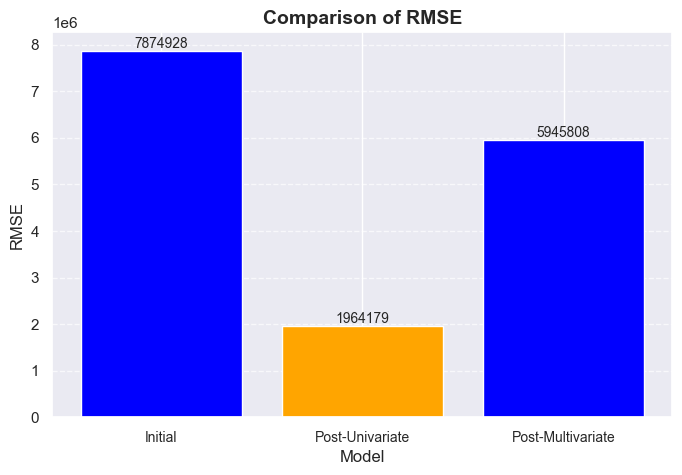

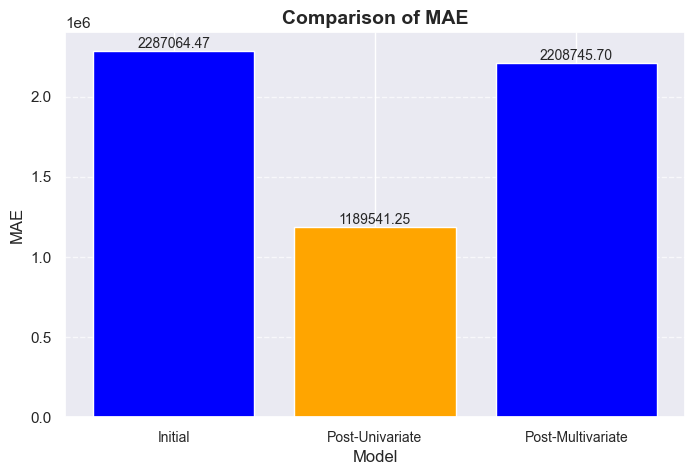

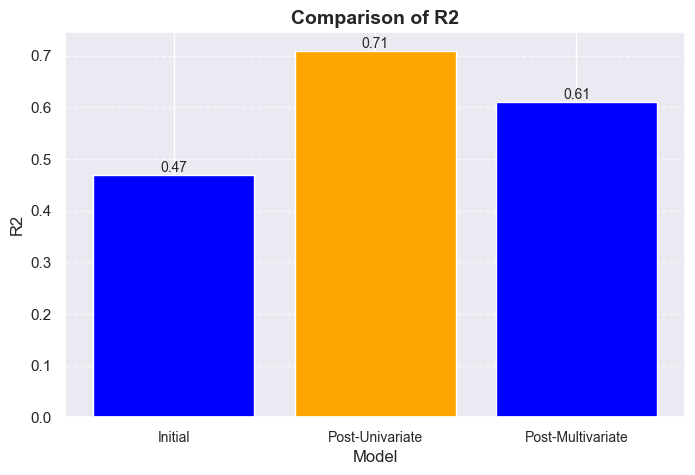

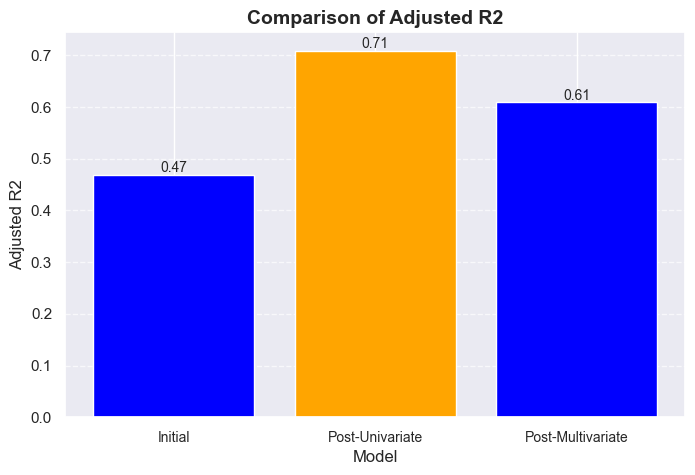

In [156]:
metrics = ['RMSE', 'MAE', 'R2', 'Adjusted R2']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics_comparison['Model'], metrics_comparison[metric], color=['blue', 'orange'])
    plt.title(f'Comparison of {metric}', fontsize=14, fontweight='bold')
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            f'{bar.get_height():.2f}' if metric != 'RMSE' else f'{bar.get_height():.0f}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )

    plt.show()


Key Observations:

1. Reduction in Error:

- RMSE decreased from 5,388,559.38 to 1,964,178.56, representing a 3.63-fold improvement.
- MAE was similarly reduced significantly, indicating that predictions became much closer to the actual values on average.

2. Improved Predictive Strength:


- R 
2
  increased from 0.480 to 0.710, reflecting a notable improvement in the model's ability to explain the variance in the target variable.
- Adjusted 
R 
2
 , which accounts for the number of predictors, also rose from 0.478 to 0.709, confirming that the improvement wasn't due to overfitting.

3. Impact of Univariate Analysis:

- Univariate analysis improved the model by handling outliers, noise, missing values, and adding relevant features.
- This enhanced the quality of data used for training, which is critical for building a robust predictive model.


### Post-multivariate

In [107]:
metrics_comparison_mult = pd.read_csv('./Metrics_mult.csv')

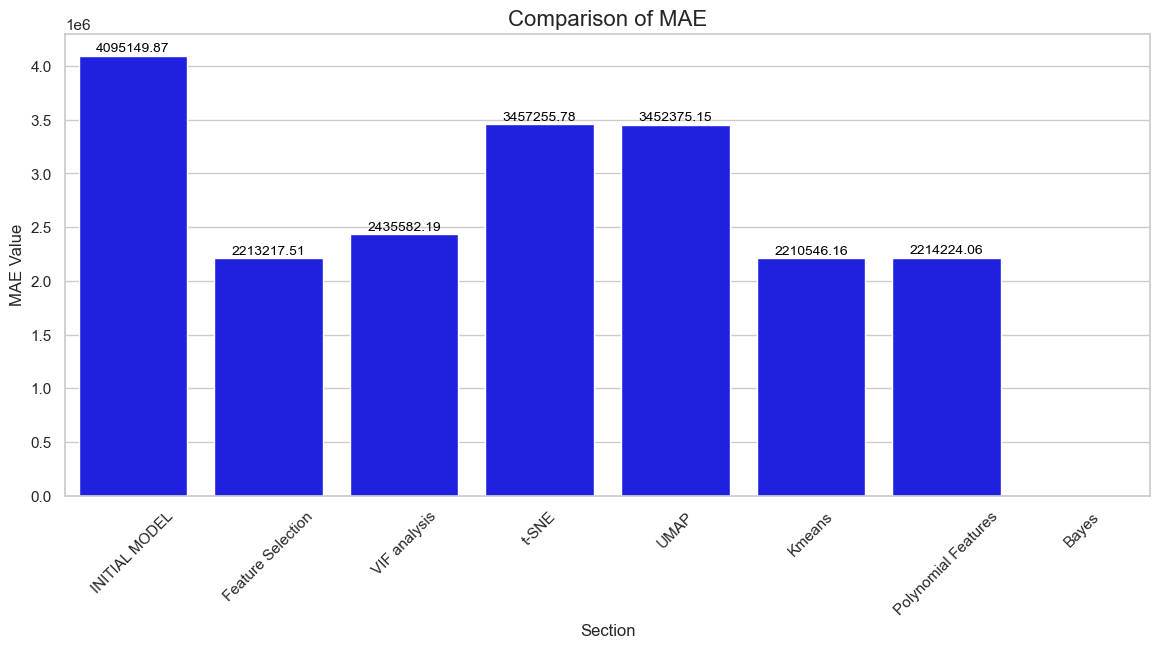

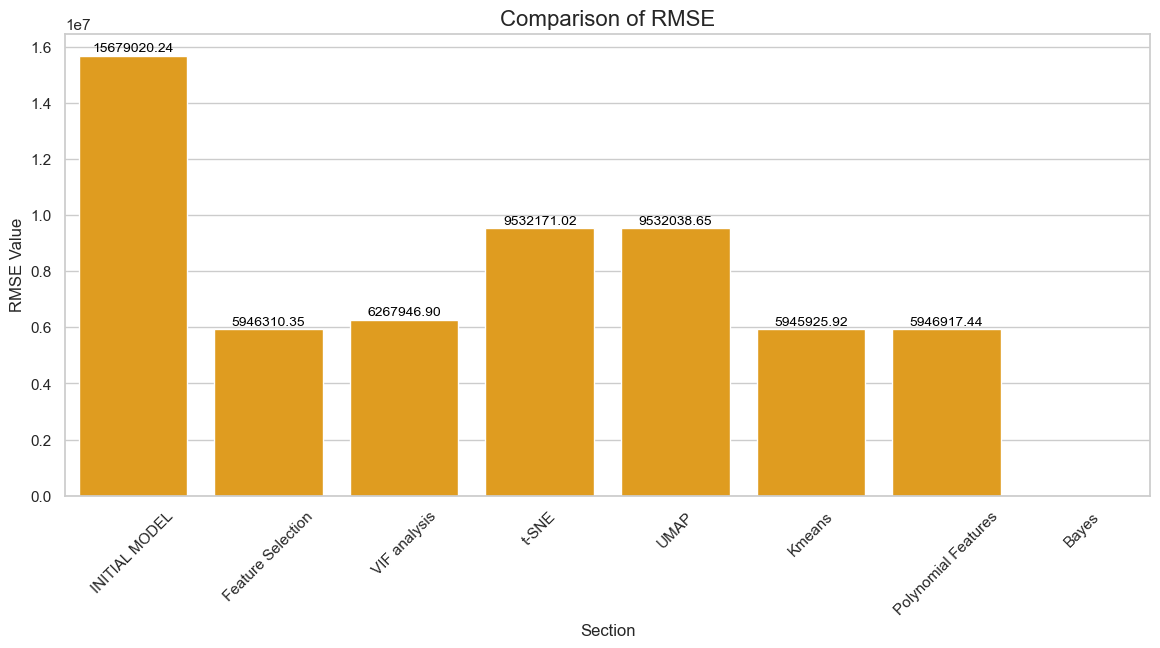

C:\Users\Sofia\AppData\Local\Temp\ipykernel_8696\3959666751.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Section", y="R²", data=metrics_data, palette="viridis")


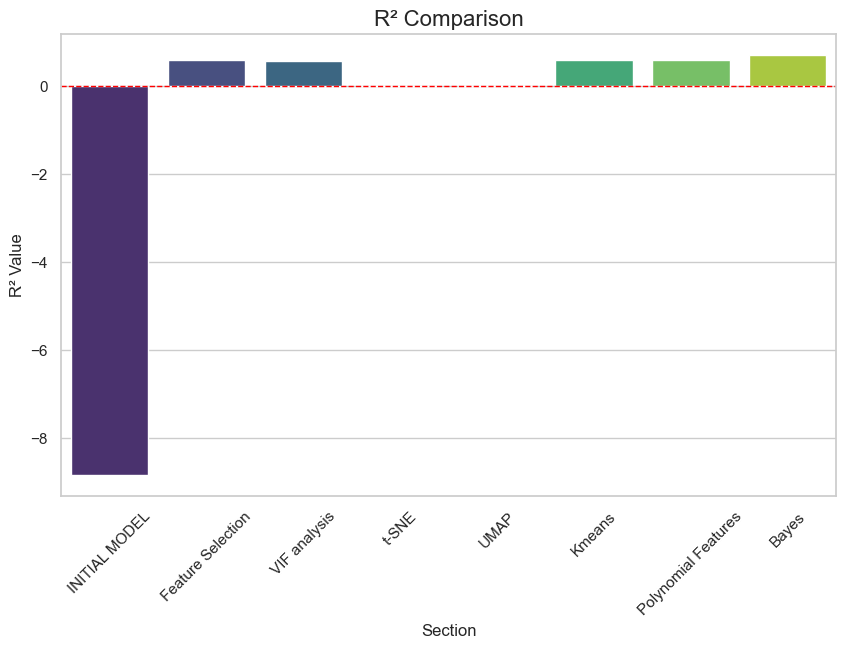

In [110]:
metrics_data = metrics_comparison_mult 

sns.set_style("whitegrid")

# Plot MAE comparison
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Section", y="MAE", data=metrics_data, color="blue")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title("Comparison of MAE", fontsize=16)
plt.ylabel("MAE Value")
plt.xticks(rotation=45)
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Section", y="RMSE", data=metrics_data, color="orange")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title("Comparison of RMSE", fontsize=16)
plt.ylabel("RMSE Value")
plt.xticks(rotation=45)
plt.show()
# Plot R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Section", y="R²", data=metrics_data, palette="viridis")
plt.title("R² Comparison", fontsize=16)
plt.ylabel("R² Value")
plt.xticks(rotation=45)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()

1. MAE (Mean Absolute Error):
- The highest MAE value is observed in the INITIAL MODEL, indicating a high average absolute prediction error at this stage.
- After the Feature Selection and VIF Analysis stages, MAE significantly decreases, confirming that removing irrelevant features and addressing multicollinearity improves model accuracy.
- Both t-SNE and UMAP show increased MAE, suggesting that these approaches are less effective for this task.
- The Kmeans and Polynomial Features methods achieve the lowest MAE values, highlighting substantial improvements in prediction accuracy at these stages.
- The Bayes method also demonstrates a low MAE, reflecting consistent improvements in accuracy.

2. RMSE (Root Mean Square Error):
- The RMSE graph follows a similar trend: the INITIAL MODEL has the highest RMSE, reflecting substantial prediction errors.
- Optimization steps such as Feature Selection, VIF Analysis, and applying Kmeans lead to a significant reduction in RMSE.
- Once again, t-SNE and UMAP display higher RMSE values, indicating their limited applicability to this problem.

3. 𝑅2 (Coefficient of Determination):
- The R2 graph shows clear improvements in model quality after optimization steps:
  - The INITIAL MODEL has a negative 𝑅2 value (−8.84), signifying no predictive power.
  - After feature optimization and methods like Kmeans and Polynomial Features,R2 improves to approximately 0.61, indicating better model alignment with the data.
  - The Bayes method achieves the highest R2  value (0.72), confirming its high effectiveness for this task.
 

4. Overall Conclusions:
- Feature optimization (e.g., Feature Selection and VIF Analysis) is critical for improving model performance.
- Non-linear modeling methods such as Kmeans and Polynomial Features deliver the best results in terms of MAE and RMSE.
- The Bayes method exhibits the highest accuracy (𝑅2=0.72), making it highly suitable for the final model.


## Statistical Comparison of Model Performance

In [107]:
initial_metrics = metrics_comparison.iloc[0, 1:].tolist()  
post_univariate_metrics = metrics_comparison.iloc[1, 1:].tolist()  

print("initial_metrics", initial_metrics)
print("post_univariate_metrics", post_univariate_metrics)


initial_metrics [np.float64(7874927.96), np.float64(2287064.470622621), np.float64(0.47), np.float64(0.46789563244469656)]
post_univariate_metrics [np.float64(1964178.56), np.float64(1189541.2491387406), np.float64(0.71), np.float64(0.7091850318000296)]


In [ ]:
if len(initial_metrics) != len(post_univariate_metrics):
    raise ValueError("Both models must have the same number of observations.")

differences = np.array(initial_metrics) - np.array(post_univariate_metrics)

In [ ]:
# Paired T-Test
t_stat, p_value_ttest = ttest_rel(initial_metrics, post_univariate_metrics)
print("Paired T-Test Results:")
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value_ttest:.4f}")

In [ ]:
# Wilcoxon Signed-Rank Test
w_stat, p_value_wilcoxon = wilcoxon(initial_metrics, post_univariate_metrics)
print("\nWilcoxon Signed-Rank Test Results:")
print(f"w-statistic: {w_stat}, p-value: {p_value_wilcoxon:.4f}")

In [ ]:
alpha = 0.05  
print("\nInterpretation:")
if p_value_ttest < alpha:
    print("Paired T-Test: Significant difference between algorithms.")
else:
    print("Paired T-Test: No significant difference between algorithms.")

if p_value_wilcoxon < alpha:
    print("Wilcoxon Signed-Rank Test: Significant difference between algorithms.")
else:
    print("Wilcoxon Signed-Rank Test: No significant difference between algorithms.")

In [119]:
from numpy import mean
from numpy import std

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# create model
log_reg = LinearRegression()
X = data.drop(columns=['last_price'])
y = data['last_price']
n_splits = 3
cv = KFold(n_splits=n_splits)
# evaluate model
scorers = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
scores = cross_val_score(
    log_reg, X, y, scoring='r2', cv=cv, n_jobs=-1)
# accuracy
print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

Accuracy: 0.650 ,
Standard Deviations :0.009


In [122]:
scores = cross_val_score(
    log_reg, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

Accuracy: -1354478.417 ,
Standard Deviations :27840.234


In [123]:
scores = cross_val_score(
    log_reg, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
print('Accuracy: %.3f ,\nStandard Deviations :%.3f' %
      (mean(scores), std(scores)))

Accuracy: -2191689.160 ,
Standard Deviations :31077.846


In [116]:
LinearRegression().fit(X, y).predict(X)

array([8961264.85879922, 4166611.39883757, 6153838.93372291, ...,
       5691486.07256687, 3149163.25619382, 9857282.68821377])

In [113]:
scores

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

## Best Model Selection 

initial_metrics